# In-class (mini Project 4) -- image enhancement -- MCEN 1030

In this project we'll examine some image processing tools within a Python package called scikit-image. This package is built on NumPy and is doing a lot of 2D array manipulation "under the hood".

For someone applying the algorithms we will discuss here, there is a logic to them -- the gamma correction described above will darken dark areas for certain values, and brighten them up for others. But there is inarguably an element of "taste" involved, wherein you make an adjustment and assess the results. We will mostly just be experimenting with these tools. 

You can read about the documentation here: https://scikit-image.org/docs/0.24.x/user_guide/index.html

...and I'll be asking you to analyze an image from here: https://mars.nasa.gov/mars2020/multimedia/raw-images/

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# if you are running this in Colab, need to uncomment this line:
#!pip install scikit-image 
from skimage import io, img_as_float
from skimage.color import rgb2gray
from skimage import exposure

## Examine the unenhanced image

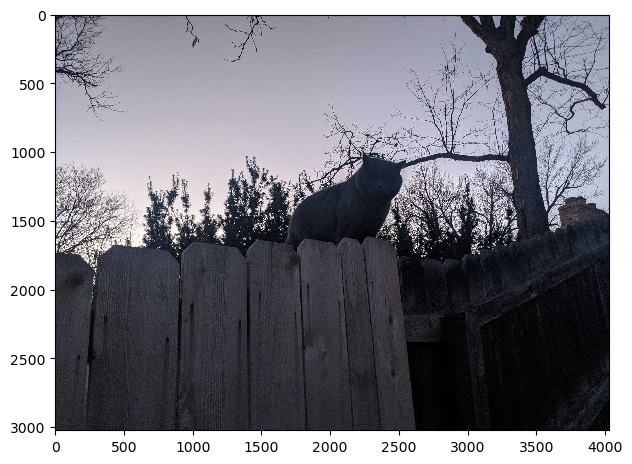

In [4]:
img= io.imread("LB.jpg")
# img= io.imread("Mars_Perseverance_FRM_1342_0786077120_270ECM_N0622066FHAZ00230_00_2LLJ.png")
bw = rgb2gray(img) # we'll focus on black and white images, and this will turn a color image to black and white
image = img_as_float(bw)

io.imshow(img, cmap=plt.cm.gray)
plt.show()

## Enhance! Part 1

Let's dive straight into some enhancements using code that is lightly modified from the scikit-image documentation. The first type of enhancement we will consider is called "histogram equilization". In this context, we examine a histogram based on the pixel intensities. In the example image above, there are about 12 million pixels, how many of them are all the way black? How many white? How many are 90% white? Et cetera. We can get that information no problem -- I bet we could program it from scratch in NumPy in about 5 minutes since we've already got the image uploaded. But there are built in tools to do that for us.

With "histogram equalization" we are going to modify the intensities of the pixels such that they span the range from black to white "better", with "better" depends on the context. Let's just take a look, it's easier to look at the charts than explain theoretically.

(I actually have picked an extremely tricky example...)

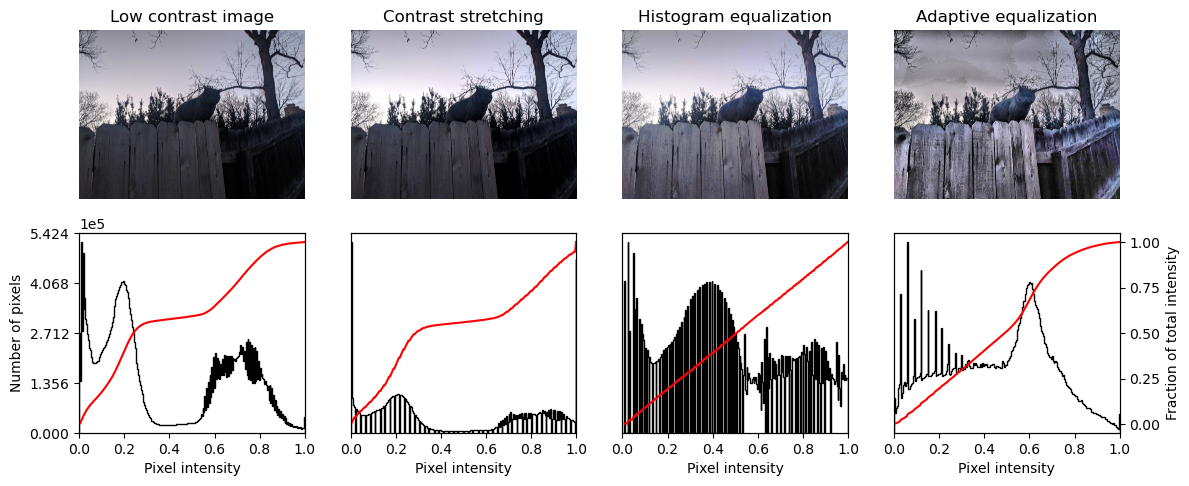

In [14]:
def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram."""
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf



# Contrast stretching
p5, p95 = np.percentile(img, (5, 95))
img_rescale = exposure.rescale_intensity(img, in_range=(p5, p95))

# Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

# Display results
fig = plt.figure(figsize=(12, 5))
axes = np.zeros((2, 4), dtype=object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1 + i, sharex=axes[0, 0], sharey=axes[0, 0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5 + i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

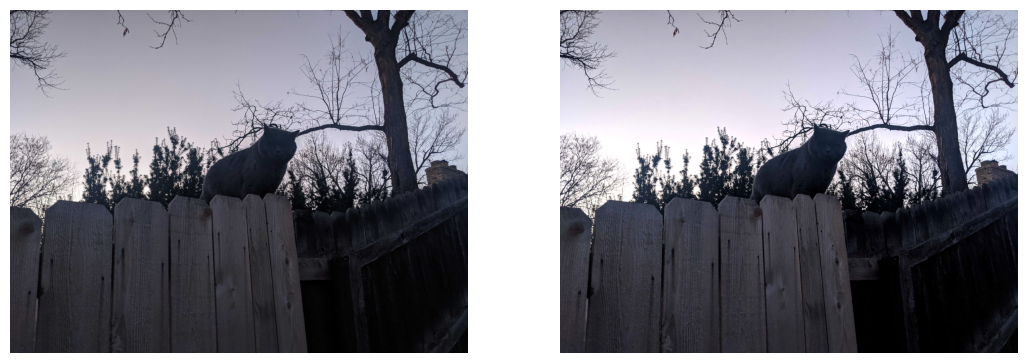

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
ax1.imshow(img)
ax2.imshow(img_rescale)
ax1.set_axis_off()
ax2.set_axis_off()
plt.show()

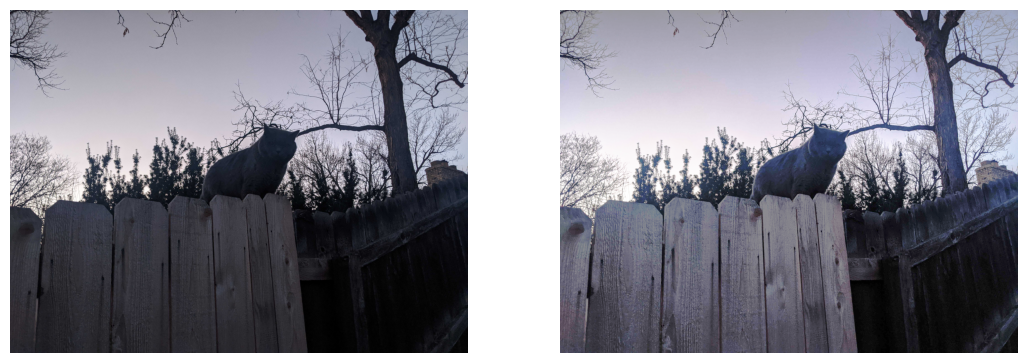

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
ax1.imshow(img)
ax2.imshow(img_eq)
ax1.set_axis_off()
ax2.set_axis_off()
plt.show()

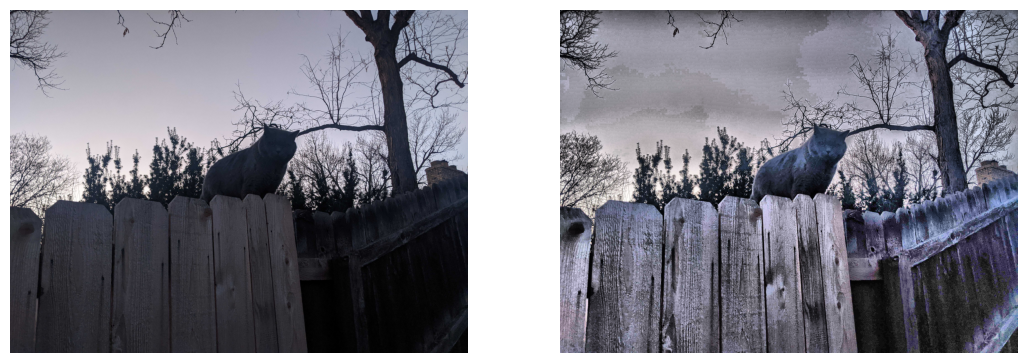

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
ax1.imshow(img)
ax2.imshow(img_adapteq)
ax1.set_axis_off()
ax2.set_axis_off()
plt.show()

## Enhance! Part 2

The above algorithms ostensibly stretch out the distribution of pixel intensities to that it better spans the range of possible values. We could also adjust the distributions non-uniformly (non-linearly), and two tools to do that are the "gamma correction" and "log correction".

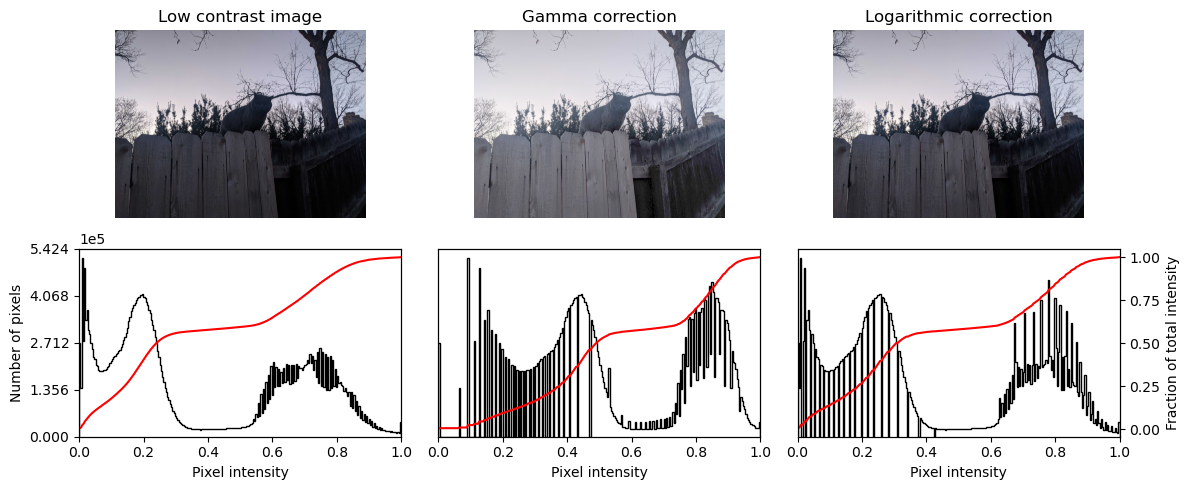

In [22]:
def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram."""
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf


# Gamma
# there is an adjustable parameter here... putting it at 0.5
gamma_corrected = exposure.adjust_gamma(img, .5)

# Logarithmic
# there is an adjustable parameter here... putting it at 1
logarithmic_corrected = exposure.adjust_log(img, 1)

# Display results
fig = plt.figure(figsize=(12, 5))
axes = np.zeros((2, 3), dtype=object)
axes[0, 0] = plt.subplot(2, 3, 1)
axes[0, 1] = plt.subplot(2, 3, 2, sharex=axes[0, 0], sharey=axes[0, 0])
axes[0, 2] = plt.subplot(2, 3, 3, sharex=axes[0, 0], sharey=axes[0, 0])
axes[1, 0] = plt.subplot(2, 3, 4)
axes[1, 1] = plt.subplot(2, 3, 5)
axes[1, 2] = plt.subplot(2, 3, 6)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(gamma_corrected, axes[:, 1])
ax_img.set_title('Gamma correction')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(logarithmic_corrected, axes[:, 2])
ax_img.set_title('Logarithmic correction')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

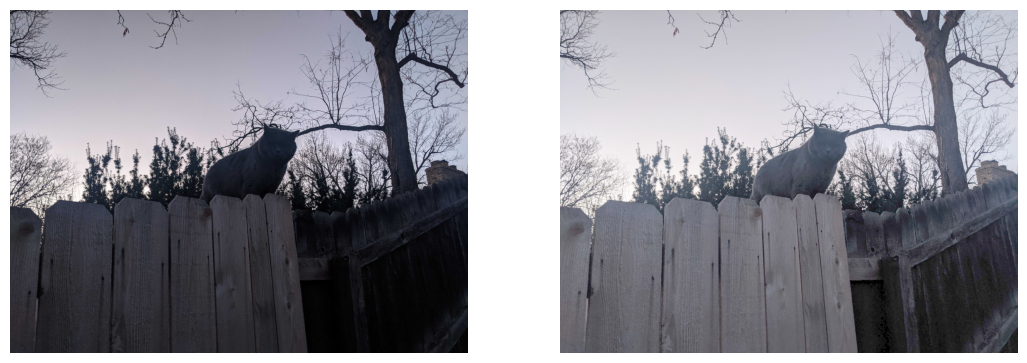

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
ax1.imshow(img)
ax2.imshow(gamma_corrected)
ax1.set_axis_off()
ax2.set_axis_off()
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
ax1.imshow(img)
ax2.imshow(logarithmic_corrected)
ax1.set_axis_off()
ax2.set_axis_off()
plt.show()

## Enhance! Part 3

We can of course do multiple operations to the image...

In [ ]:
gamma_corrected = exposure.adjust_gamma(img, .5) # the 0.5 is a tunable parameter
img_gamma_and_eq = exposure.equalize_hist(gamma_corrected)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
ax1.imshow(img)
ax2.imshow(img_gamma_and_eq)
ax1.set_axis_off()
ax2.set_axis_off()
plt.show()

In [ ]:
fig, ax= plt.subplots(1, 1, figsize=(13, 11))
ax.imshow(img_gamma_and_eq)
ax.set_axis_off()
plt.show()